# Linguagem Natural: Introdução ao NLP com análise de sentimento

Material referente aos cursos da Alura disponíveis [aqui (Pt. 1)](https://cursos.alura.com.br/course/introducao-a-nlp-com-analise-de-sentimento) e [aqui (Pt. 2)](https://cursos.alura.com.br/course/nlp-com-analise-de-sentimento).

## Informações sobre a aula:

1. O Dataset textual não pode ser diretamente classificado por um classificador como o `LogisticRegression`, visto que não está ainda 'traduzido' para a linguagem de máquina e essa é a função do NLP.

## Preparando o ambiente

In [1]:
!pip install wordcloud
!pip install --user -U nltk --no-warn-script-location
!pip install Unidecode

In [2]:
%matplotlib inline

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from string import punctuation
import unidecode
from IPython.display import clear_output

In [4]:
SEED = 42
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\salat\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Carregando os dados

In [5]:
resenha = pd.read_csv('dados/imdb-reviews-pt-br.csv')
resenha.head()

id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   
3   4  Not even the Beatles could write songs everyon...   
4   5  Brass pictures movies is not a fitting word fo...   

                                             text_pt sentiment  
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg  
1  Este é um exemplo do motivo pelo qual a maiori...       neg  
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg  
3  Nem mesmo os Beatles puderam escrever músicas ...       neg  
4  Filmes de fotos de latão não é uma palavra apr...       neg

## Preparando os dados

In [6]:
X = resenha.text_pt
y = resenha.sentiment

In [7]:
resenha['classificacao'] = resenha['sentiment'].replace(['neg', 'pos'], [0, 1])
resenha.head()

id                                            text_en  \
0   1  Once again Mr. Costner has dragged out a movie...   
1   2  This is an example of why the majority of acti...   
2   3  First of all I hate those moronic rappers, who...   
3   4  Not even the Beatles could write songs everyon...   
4   5  Brass pictures movies is not a fitting word fo...   

                                             text_pt sentiment  classificacao  
0  Mais uma vez, o Sr. Costner arrumou um filme p...       neg              0  
1  Este é um exemplo do motivo pelo qual a maiori...       neg              0  
2  Primeiro de tudo eu odeio esses raps imbecis, ...       neg              0  
3  Nem mesmo os Beatles puderam escrever músicas ...       neg              0  
4  Filmes de fotos de latão não é uma palavra apr...       neg              0

### Bag of Words

### Exemplo de uso do `CountVectorizer`:

In [8]:
texto = ['Assisti um filme ótimo', "Assisti um filme ruim"]

vetorizar = CountVectorizer()
bag_of_words = vetorizar.fit_transform(texto)
bag_of_words

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [9]:
columns = vetorizar.get_feature_names()
columns

['assisti', 'filme', 'ruim', 'um', 'ótimo']

O retorno de `CountVectorizer.fit_transform()` é uma _matriz esparsa_, ou seja, uma matriz que é otimizada para não armazenar os valores vazios, mas apenas os preenchidos. Dessa forma, ela não pode ser diretamente usada em um DataFrame.

In [10]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=columns)
matriz_esparsa

assisti  filme  ruim  um  ótimo
0        1      1     0   1      1
1        1      1     1   1      0

### Criando o _bag of words_ para o modelo real

Para reduzir o custo computacional existe o parâmetro `max_features` para o `CountVectorizer`. Ele cria os vetores apenas com as N palavras mais usadas.

In [11]:
vetorizar = CountVectorizer(max_features=100)
bag_of_words = vetorizar.fit_transform(X)
feature_names = vetorizar.get_feature_names()
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=feature_names)
matriz_esparsa.head()

ainda  algumas  alguns  anos  ao  apenas  as  assistir  até  bem  ...  \
0      0        0       0     0   1       0   0         0    1    1  ...   
1      1        0       0     0   0       0   0         3    0    2  ...   
2      0        0       0     0   0       0   0         0    0    0  ...   
3      1        0       0     1   0       1   4         0    2    1  ...   
4      0        1       0     0   0       1   2         1    0    1  ...   

   todos  tudo  tão  um  uma  ver  vez  vi  vida  você  
0      0     1    0   3    2    0    1   0     0     0  
1      1     0    0   5    2    4    0   1     0     1  
2      1     2    1   3    2    0    1   0     0     2  
3      2     0    0   7    4    1    0   1     0     1  
4      0     0    0   3    4    0    0   0     0     0  

[5 rows x 100 columns]

## Realizando a classificação com `LogisticRegression`

In [12]:
X_train, X_test, y_train, y_test = train_test_split(matriz_esparsa, y, stratify=y, random_state=SEED)

In [13]:
regressao_logistica = LogisticRegression()
regressao_logistica.fit(X_train, y_train)
acuracia = regressao_logistica.score(X_test, y_test)
print(acuracia)

0.7063485644965629


Note que o score não foi muito alto. Um dos problemas está em que as palavras mais usadas são palavras com pouco valor dentro do texto (_stop words_).

É interessante também registrar que para `max_features=50` a acurácia foi de 66% e para `max_features=100` foi 70%. Isso reforça a tese do problema das _stop words_.

In [14]:
def classificar_texto(X, y, max_features=100, seed=42):
    tempo_inicial = time.time()
    vetorizar = CountVectorizer(max_features=max_features)
    bag_of_words = vetorizar.fit_transform(X)
    feature_names = vetorizar.get_feature_names()
    matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=feature_names)
    matriz_esparsa.head()
    X_train, X_test, y_train, y_test = train_test_split(matriz_esparsa, y, stratify=y, random_state=seed)
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)
    acuracia = regressao_logistica.score(X_test, y_test)
    print(f'Acurácia: {acuracia}')
    print(f"Tempo de Execução: {time.time() - tempo_inicial} segundos")
    return acuracia

In [15]:
classificar_texto(X, y)

Acurácia: 0.7063485644965629
Tempo de Execução: 7.574950218200684 segundos


0.7063485644965629

## WordCloud

### Nuvem de todas as palavras

In [16]:
todas_palavras = ' '.join([texto for texto in X])

In [17]:
def criar_nuvem(X, todas_palavras):
    nuvem_palavras = WordCloud(background_color="white", max_words=1000, width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(16,9))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show();

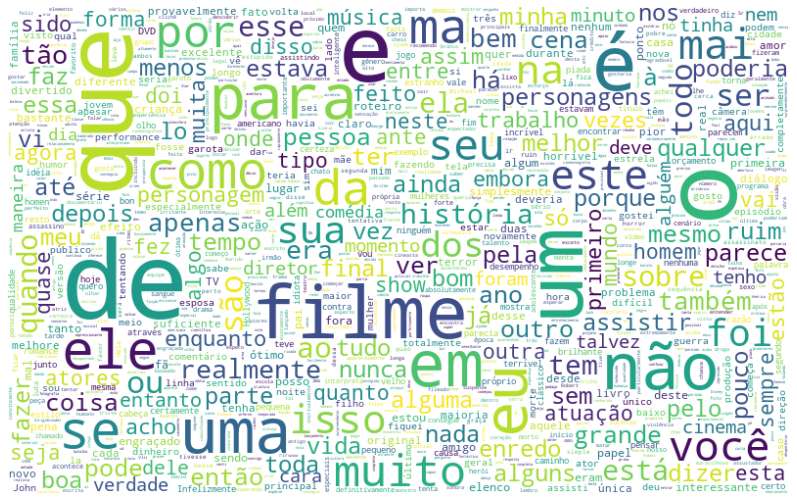

In [18]:
criar_nuvem(X, todas_palavras)

### Palavras positivas

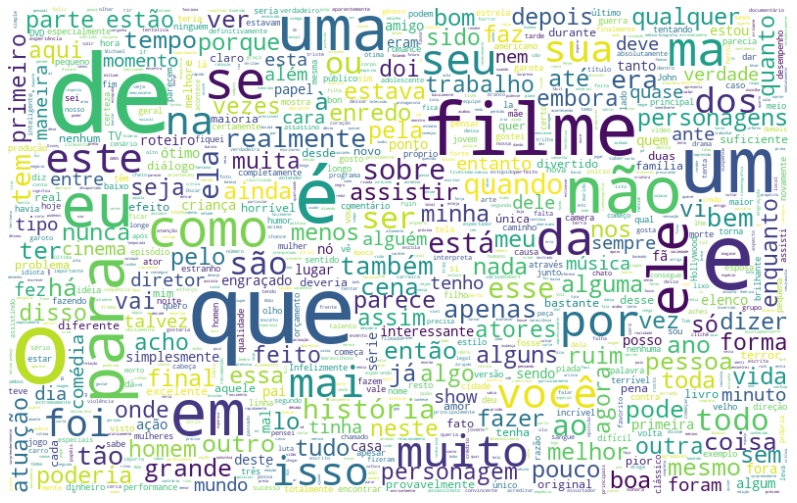

In [19]:
criar_nuvem(resenha.query("sentiment == 'pos'")['text_pt'], todas_palavras)

### Palavras negativas

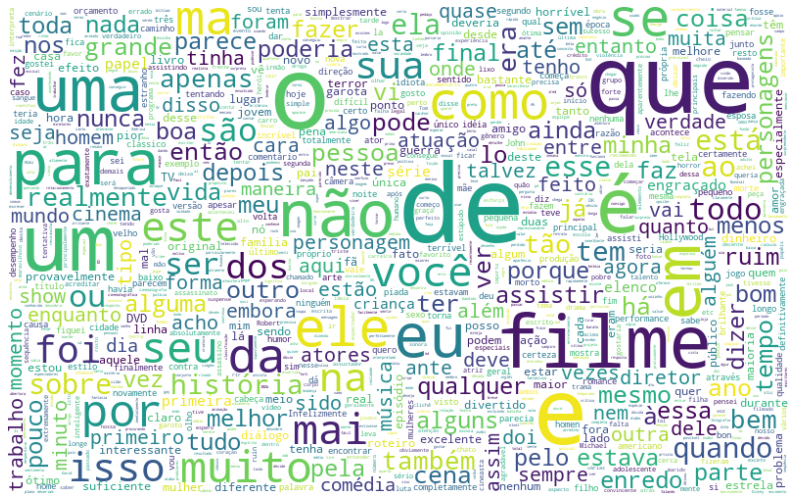

In [20]:
criar_nuvem(resenha.query("sentiment == 'neg'")['text_pt'], todas_palavras)

 ## NLTK

### Testando a utilização

In [21]:
frase = ['um filme ruim', 'um filmebom']
frequencia = nltk.FreqDist(frase)
frequencia

FreqDist({'um filme ruim': 1, 'um filmebom': 1})

In [22]:
frase = "Bem vindo ao mundo do PLT!"
token_frase = nltk.tokenize.WhitespaceTokenizer().tokenize(frase)
token_frase

['Bem', 'vindo', 'ao', 'mundo', 'do', 'PLT!']

### Aplicando para o IMDB

In [23]:
token_frase = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)

In [24]:
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()), "Frequência": list(frequencia.values())})

In [25]:
most_frequent = df_frequencia.nlargest(columns="Frequência", n = 50)

### Utilizando Gráfico de Pareto

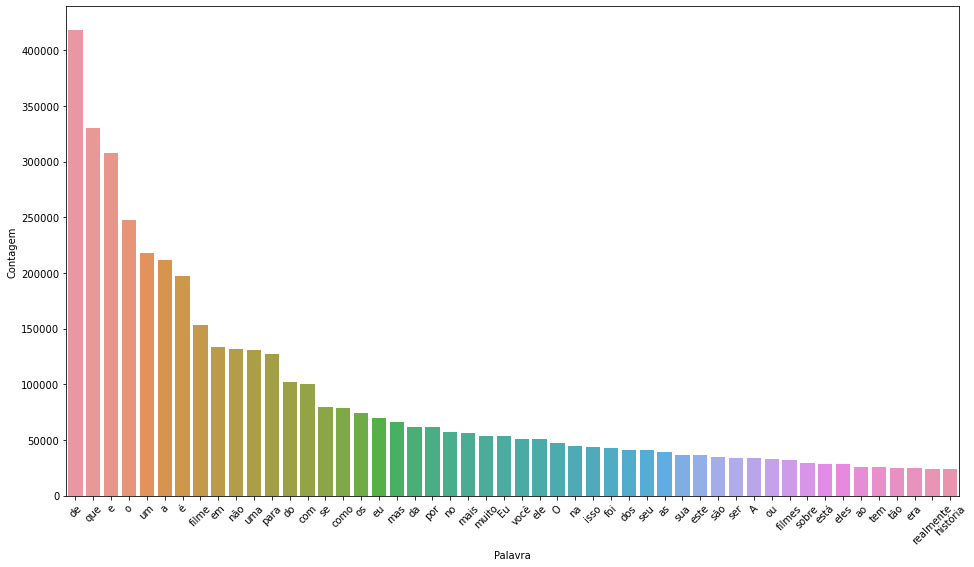

In [26]:
plt.figure(figsize=(16,9))
ax = sns.barplot(data=most_frequent, x='Palavra', y='Frequência')
ax.set(ylabel='Contagem')
plt.xticks(rotation=45)
plt.show()

### Criando a função

In [27]:
def pareto(texto, coluna_texto, n = 50):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = nltk.tokenize.WhitespaceTokenizer().tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()), "Frequência": list(frequencia.values())})
    most_frequent = df_frequencia.nlargest(columns="Frequência", n = n)
    
    total = most_frequent['Frequência'].sum()
    most_frequent['Porcentagem'] = most_frequent['Frequência'].cumsum() / total * 100
    
    plt.figure(figsize=(16,9))    
    ax = sns.barplot(data=most_frequent, x='Palavra', y='Frequência')
    plt.xticks(rotation=45)
    ax2 = ax.twinx()
    ax.set(ylabel='Contagem')
    sns.lineplot(data=most_frequent, x='Palavra', y='Porcentagem', color='red', sort=False, ax=ax2)    
    plt.show();

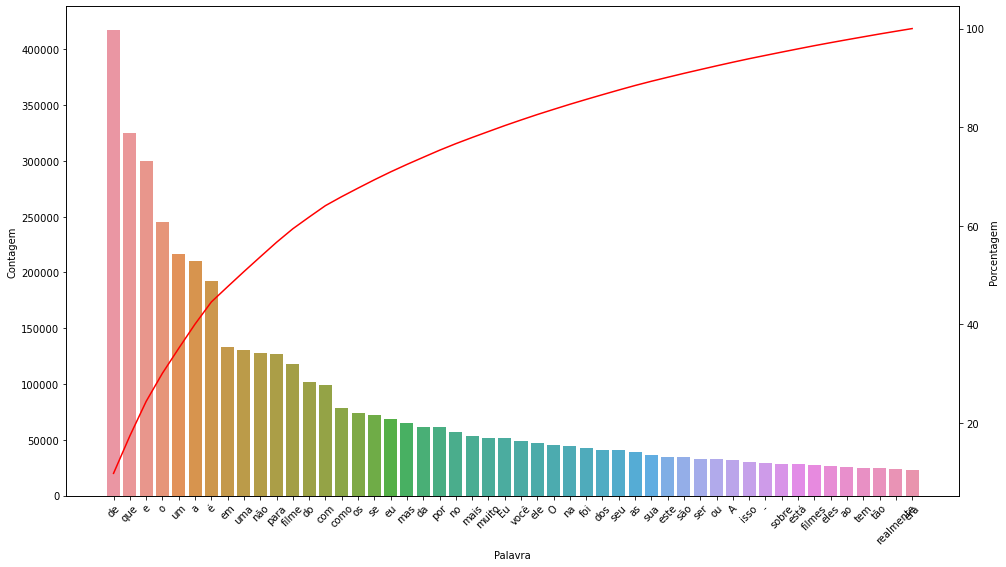

In [28]:
pareto(resenha, 'text_pt', n = 50)

## StopWords

Abaixo são realizados os seguintes tratamentos:

1. Remoção de palavras irrelevantes (_stop words_)
2. Remoção de algumas palavras adicionais que não estão nas definidas pela biblioteca
3. Remoção da pontuação (`punctuation`)
4. Remoção da acentuação (`unicode.unicode`)
5. Transformação do texto para minúsculo.

In [29]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese") + list(punctuation)
palavras_irrelevantes.append('filme')
palavras_irrelevantes.append('eu')
palavras_irrelevantes.append('Eu')
palavras_irrelevantes.append('Ele')
palavras_irrelevantes.append('ele')
palavras_irrelevantes.append('O')
palavras_irrelevantes = [unidecode.unidecode(texto) for texto in palavras_irrelevantes]

In [30]:
todas_palavras = ' '.join([texto for texto in resenha['text_pt']])
palavras_texto = nltk.tokenize.WordPunctTokenizer().tokenize(unidecode.unidecode(todas_palavras))
palavras_importantes = list()
for palavra in palavras_texto:
    if((palavra.lower() not in palavras_irrelevantes) and (len(palavra) > 1)):
        palavras_importantes.append(palavra)

print(len(todas_palavras))
print(len(palavras_importantes))

63448424
5892120


Note que haverá uma redução considerável no número de palavras utilizadas.

In [31]:
frase_processada = list()
for opiniao in resenha.text_pt:
    nova_frase = list()
    palavras_texto = nltk.tokenize.WordPunctTokenizer().tokenize(unidecode.unidecode(opiniao))
    for palavra in palavras_texto:
        if(palavra.lower() not in palavras_irrelevantes and len(palavra) > 1):
            nova_frase.append(palavra.lower())
    frase_processada.append(' '.join(nova_frase))

resenha['tratamento_1'] = frase_processada

### Verificando se houve melhora nas predições

In [32]:
classificar_texto(resenha['tratamento_1'], y)

Acurácia: 0.7226041245450869
Tempo de Execução: 5.293367147445679 segundos


0.7226041245450869

Houve uma melhora de aproximadamente 2% na acurácia. No entando a remoção das _stop words_ não busca apenas aumentar a acurácia do modelo, mas aumentar a performance de execução da classificação.

#### Comparando a performance das classificações

In [33]:
classificar_texto(resenha['text_pt'], y)
classificar_texto(resenha['tratamento_1'], y)

Acurácia: 0.7063485644965629
Tempo de Execução: 7.674054384231567 segundos
Acurácia: 0.7226041245450869
Tempo de Execução: 5.082699775695801 segundos


0.7226041245450869

A classificação com o valor total dos textos teve, além da acurácia inferior, uma tempo significativamente maior (7.15s) do que com o modelo tratado (4.86s).

### Visualizando os dados tratados

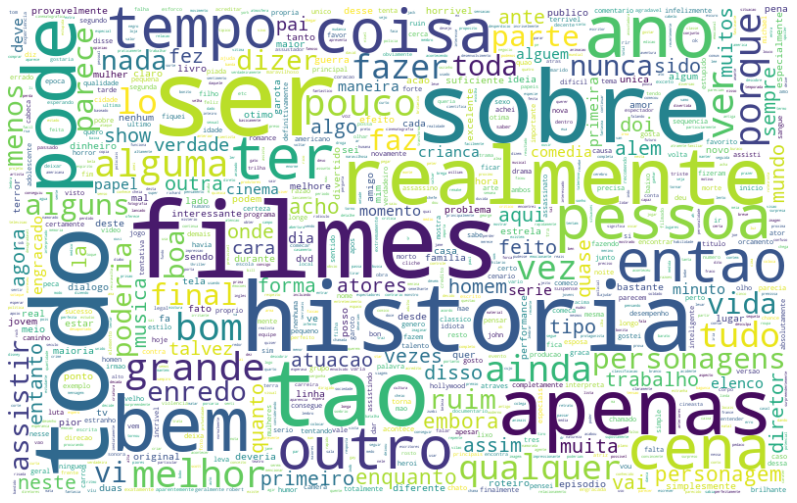

In [34]:
palavras = ' '.join([texto for texto in resenha['tratamento_1']])
criar_nuvem(resenha['tratamento_1'], palavras)

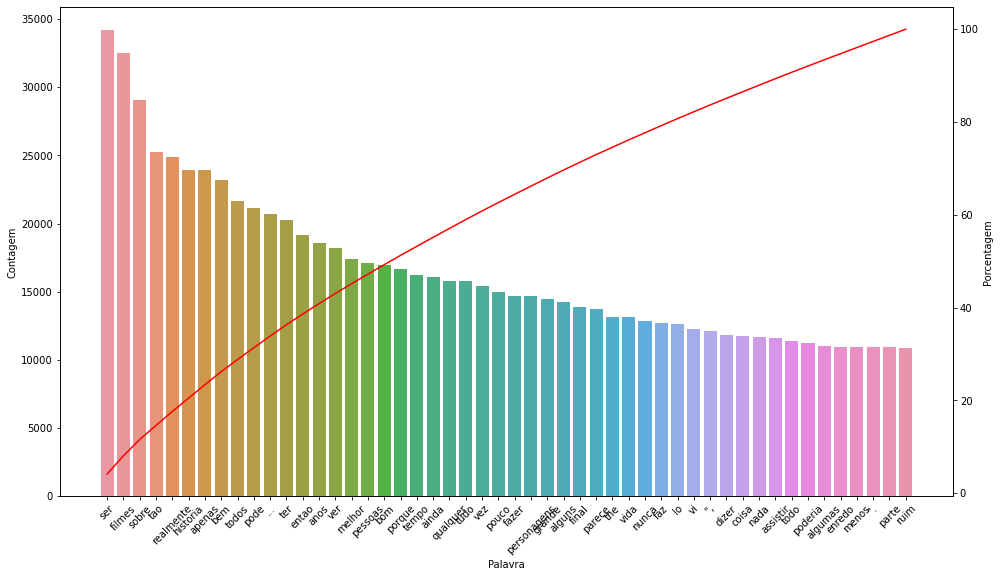

In [35]:
pareto(resenha, 'tratamento_1', n = 50)

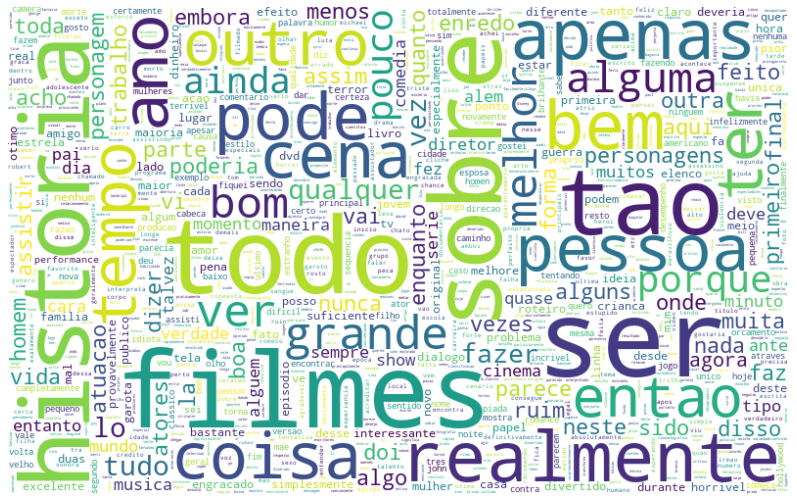

In [36]:
criar_nuvem(resenha.query("sentiment == 'pos'")['tratamento_1'], palavras)

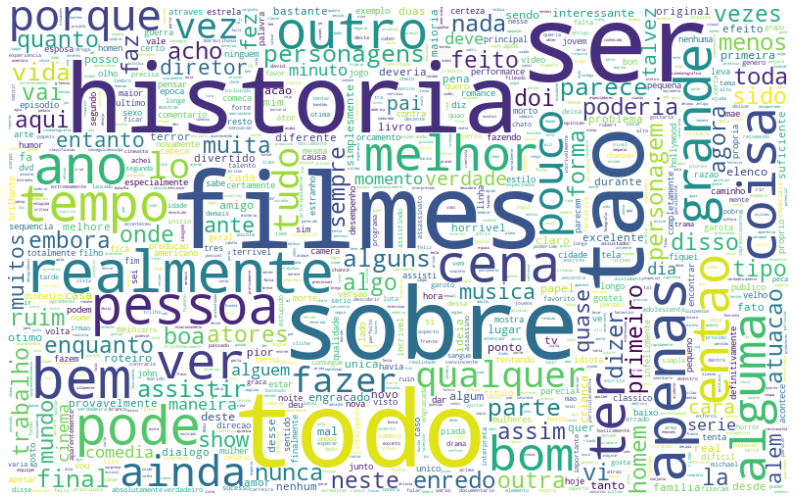

In [37]:
criar_nuvem(resenha.query("sentiment == 'neg'")['tratamento_1'], palavras)

In [38]:
resenha['tratamento_1'][0]

'vez sr costner arrumou tempo necessario alem terriveis sequencias resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armario personagem costers realizado logo inicio esquecido tarde importava personagem deveriamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armario desordenado unico obstaculo parece estar vencendo costner finalmente bem alem meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos pressagios anteriores nenhuma magica aqui tudo podia fazer desligar hora'

## Stemmer

Transformando as palavras em sua raiz.

In [39]:
stemmer = nltk.RSLPStemmer()

### Testando a funcionalidade

In [40]:
print(f'Correria: {stemmer.stem("correria")}')
print(f'Correr: {stemmer.stem("correria")}')

Correria: corr
Correr: corr


### Aplicando às resenhas

In [45]:
frase_processada = list()
tamanho = len(resenha.tratamento_1)
i = 0

for opiniao in resenha.tratamento_1:
    nova_frase = list()
    palavras_texto = nltk.tokenize.WhitespaceTokenizer().tokenize(opiniao)
    for palavra in palavras_texto:                
        nova_frase.append(stemmer.stem(palavra))        
    frase_processada.append(' '.join(nova_frase))
    clear_output(wait=True)
    i += 1
    print(f'{i}/{tamanho}')

resenha['tratamento_2'] = frase_processada

49459/49459


In [46]:
resenha['tratamento_2'][0]

'vez sr costn arrum temp necessari alem terri sequenc resgat mar qual pouc simples import nenhum person maior fantasm armari person cost realiz log inici esquec tard import person deveri import arrog superconfi ashton kutch problem sai garot pens melhor qualqu outr pesso redor mostr sinal armari desorden unic obstacul parec est venc costn final bem alem mei caminh costn cont sobr fantasm kutch inform kutch lev ser melhor pressent pressagi anteri nenhum magic aqu tud pod faz deslig hor'

In [47]:
classificar_texto(resenha['tratamento_2'], y)

Acurácia: 0.7452486858067124
Tempo de Execução: 4.078588485717773 segundos


0.7452486858067124

Note que a acurácia agora foi de 74.5%, uma suba considerável apenas com a remoção das raízes. Além disso, o tempo de execução também apresentou uma pequena melhora.

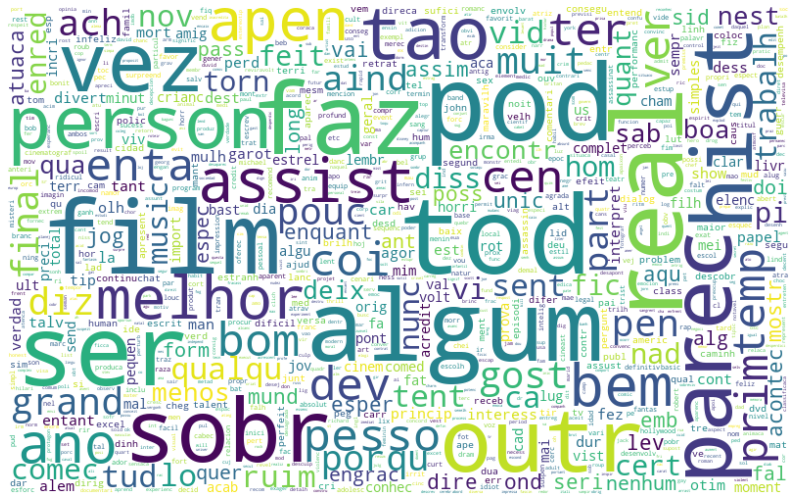

In [48]:
palavras = ' '.join([texto for texto in resenha['tratamento_2']])
criar_nuvem(resenha['tratamento_1'], palavras)

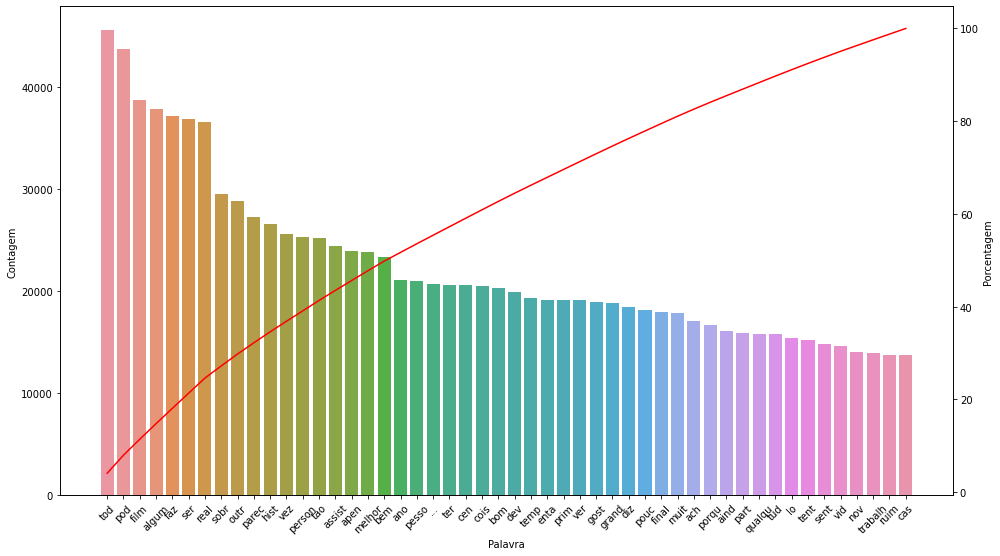

In [49]:
pareto(resenha, 'tratamento_2', n = 50)

## TF-IDF

### Testando funcionalidade

In [50]:
frases = ['Assisti um filme ótimo', 'Assisti um filme péssimo']
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
caracteristicas = tfidf.fit_transform(frases)
pd.DataFrame(caracteristicas.todense(), columns=tfidf.get_feature_names())

Assisti     filme   péssimo        um     ótimo
0  0.448321  0.448321  0.000000  0.448321  0.630099
1  0.448321  0.448321  0.630099  0.448321  0.000000

### Aplicando aos dados

In [73]:
def classificar_dados_tfidf(data, max_features=100, seed=42):
    tempo_inicial = time.time()
    vetorizar = TfidfVectorizer(lowercase=False, max_features=max_features)
    bag_of_words = vetorizar.fit_transform(data)    
    X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, random_state=seed)
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)
    acuracia_teste = regressao_logistica.score(X_test, y_test)
    acuracia_treino = regressao_logistica.score(X_train, y_train)
    
    print(f'Acurácia treino: {acuracia_treino}')
    print(f'Acurácia teste: {acuracia_teste}')    
    print(f"Tempo de Execução: {time.time() - tempo_inicial} segundos")
    
    return (regressao_logistica, acuracia_treino, acuracia_teste)

In [74]:
classificar_dados_tfidf(resenha['tratamento_2'])

Acurácia treino: 0.747722003558527
Acurácia teste: 0.7458956732713303
Tempo de Execução: 3.616720199584961 segundos


(LogisticRegression(), 0.747722003558527, 0.7458956732713303)

Houve um pequeno aumento na acurácia, mas menor do que o apresentado na aula. No entanto, o tempo de execução reduziu drasticamente. Com isso, é possível inclusive aumentar o número de features utilizadas:

In [75]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=200)

Acurácia treino: 0.7988084326306141
Acurácia teste: 0.7953093408815204
Tempo de Execução: 3.9032480716705322 segundos


(LogisticRegression(), 0.7988084326306141, 0.7953093408815204)

In [76]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=400)

Acurácia treino: 0.8365234269693211
Acurácia teste: 0.8312171451678124
Tempo de Execução: 3.8636386394500732 segundos


(LogisticRegression(), 0.8365234269693211, 0.8312171451678124)

In [77]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=800)

Acurácia treino: 0.8651533940799051
Acurácia teste: 0.857339264051759
Tempo de Execução: 3.96893572807312 segundos


(LogisticRegression(), 0.8651533940799051, 0.857339264051759)

In [78]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=1600)

Acurácia treino: 0.8847522510379037
Acurácia teste: 0.8717347351395067
Tempo de Execução: 3.9643540382385254 segundos


(LogisticRegression(), 0.8847522510379037, 0.8717347351395067)

In [79]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=3200)

Acurácia treino: 0.8998220736507252
Acurácia teste: 0.8773150020218359
Tempo de Execução: 4.436085939407349 segundos


(LogisticRegression(), 0.8998220736507252, 0.8773150020218359)

In [80]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=6400)

Acurácia treino: 0.909931525314067
Acurácia teste: 0.8816012939749293
Tempo de Execução: 4.5809619426727295 segundos


(LogisticRegression(), 0.909931525314067, 0.8816012939749293)

In [81]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=12800)

Acurácia treino: 0.9172372890494419
Acurácia teste: 0.8844318641326324
Tempo de Execução: 4.858686685562134 segundos


(LogisticRegression(), 0.9172372890494419, 0.8844318641326324)

In [82]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=25600)

Acurácia treino: 0.9205262306572491
Acurácia teste: 0.8845127375657097
Tempo de Execução: 5.045138835906982 segundos


(LogisticRegression(), 0.9205262306572491, 0.8845127375657097)

A partir de 1600 features a acurácia não teve um aumento significativo. É interessante observar como esse cálculo aumentuo consideravelmente a performance do algoritmo. Em 4s para 3200 features com uma acurácia de aproximadamente 87.73%.

Uma outra observação interessante a se fazer é que conforme o número de features aumenta, também aumentao overfitting.

## Ngrams

In [85]:
frase = "Assisti um ótimo filme."
frase_separada = nltk.tokenize.WhitespaceTokenizer().tokenize(frase)
pares = nltk.ngrams(frase_separada, 2)
print(list(pares))

[('Assisti', 'um'), ('um', 'ótimo'), ('ótimo', 'filme.')]


In [86]:
def classificar_dados_tfidf(data, max_features=100, seed=42):
    tempo_inicial = time.time()
    vetorizar = TfidfVectorizer(lowercase=False, max_features=max_features, ngram_range = (1, 2))
    bag_of_words = vetorizar.fit_transform(data)    
    X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, random_state=seed)
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)
    acuracia_teste = regressao_logistica.score(X_test, y_test)
    acuracia_treino = regressao_logistica.score(X_train, y_train)
    
    print(f'Acurácia treino: {acuracia_treino}')
    print(f'Acurácia teste: {acuracia_teste}')    
    print(f"Tempo de Execução: {time.time() - tempo_inicial} segundos")
    
    return (regressao_logistica, acuracia_treino, acuracia_teste)

In [88]:
classificar_dados_tfidf(resenha['tratamento_2'], max_features=1600)

Acurácia treino: 0.8869898096727233
Acurácia teste: 0.8724625960372018
Tempo de Execução: 18.58018207550049 segundos


(LogisticRegression(), 0.8869898096727233, 0.8724625960372018)

Houve uma pequena melhora na acurácia a um custo de aumentar significativamente o tempo de execução do algoritmo.